In [23]:
import json

with open('results/model-eval-amd-7950x3d-rtx4080.json', 'r') as file:
    data = json.load(file)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

records = []
for model, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'model': model,
            'tool': tool,
            'pass_percentage': metrics['pass_percentage'],
            'median_latency': metrics['median_latency']
        })

df = pd.DataFrame(records)


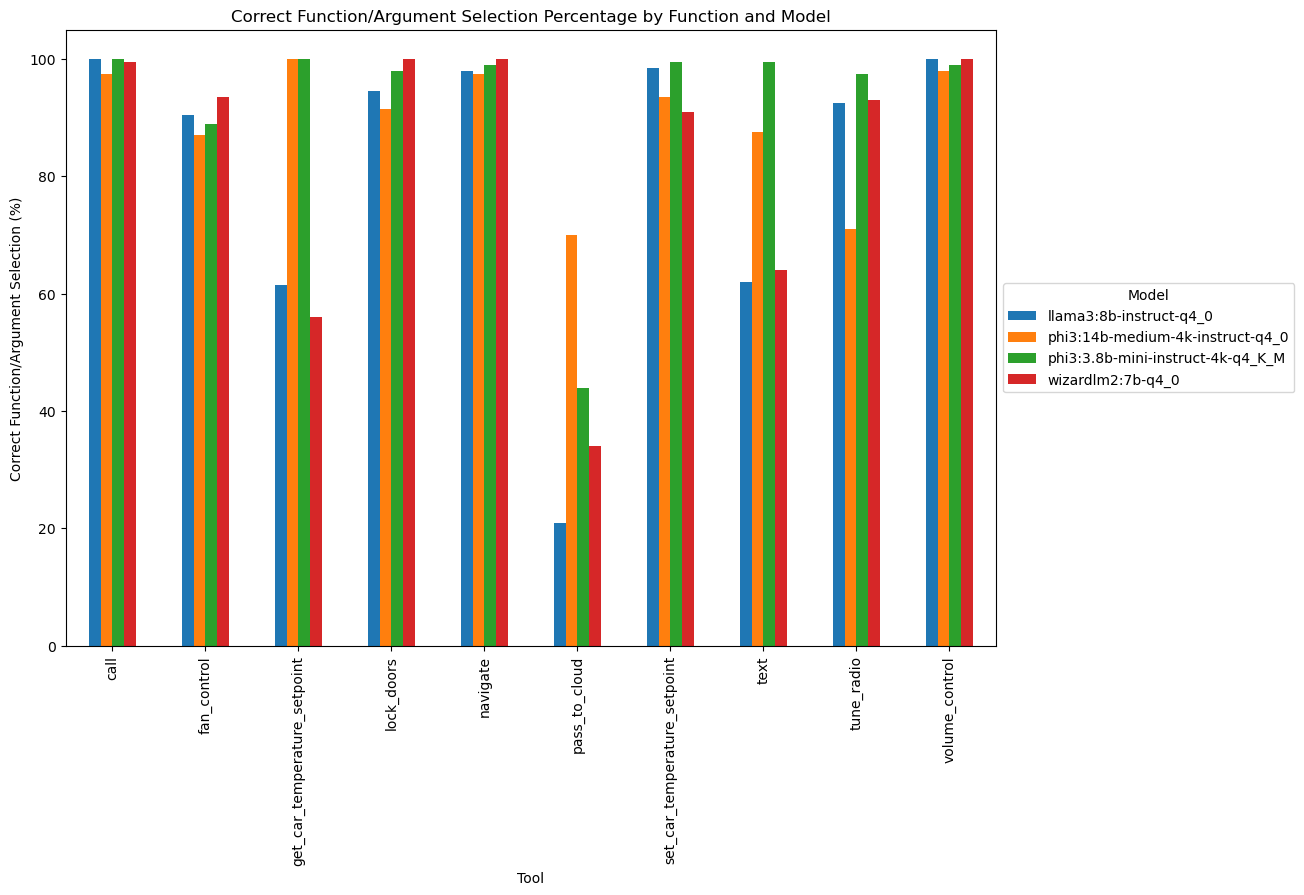

In [25]:

# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Function/Argument Selection Percentage by Function and Model')
plt.xlabel('Tool')
plt.ylabel('Correct Function/Argument Selection (%)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

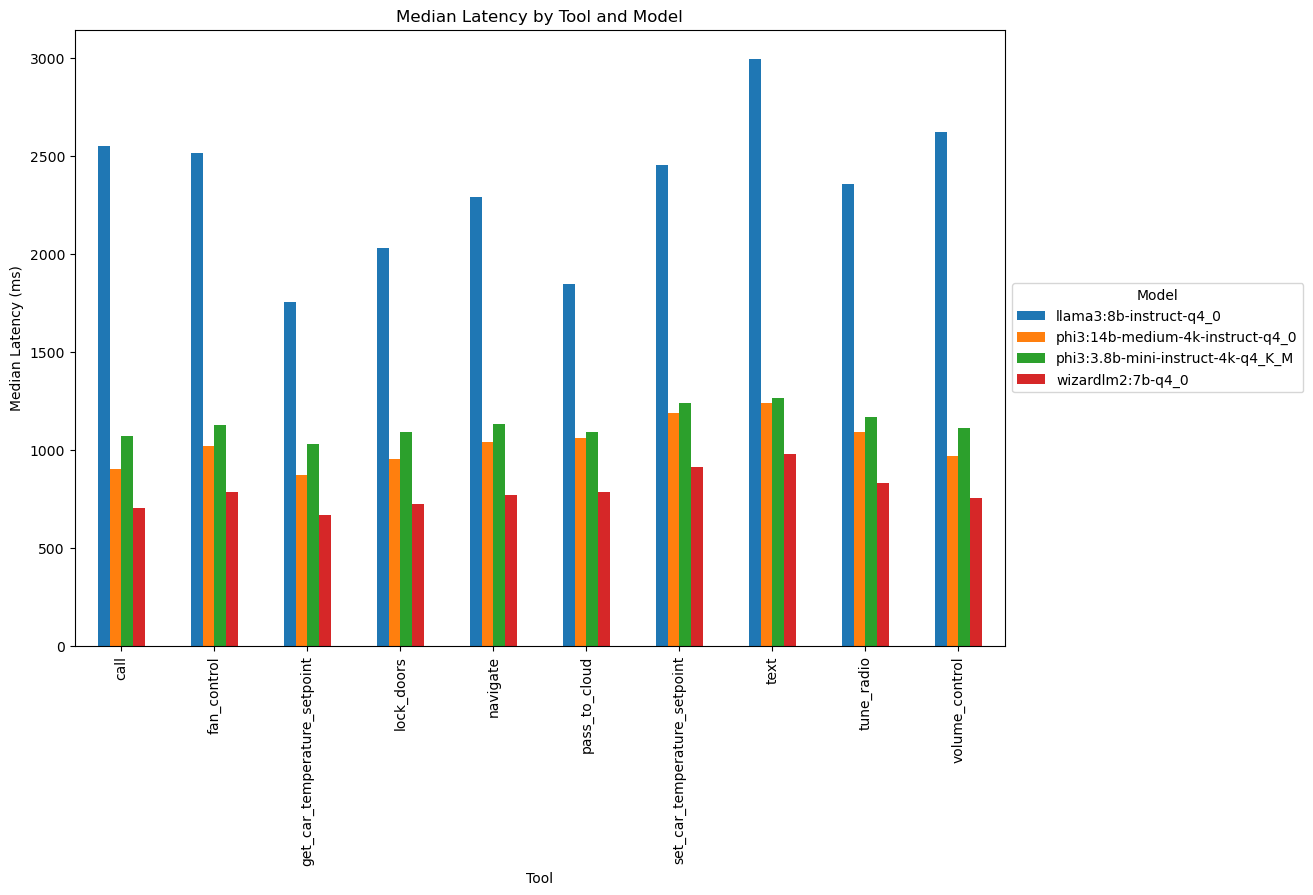

In [26]:
# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool and Model')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

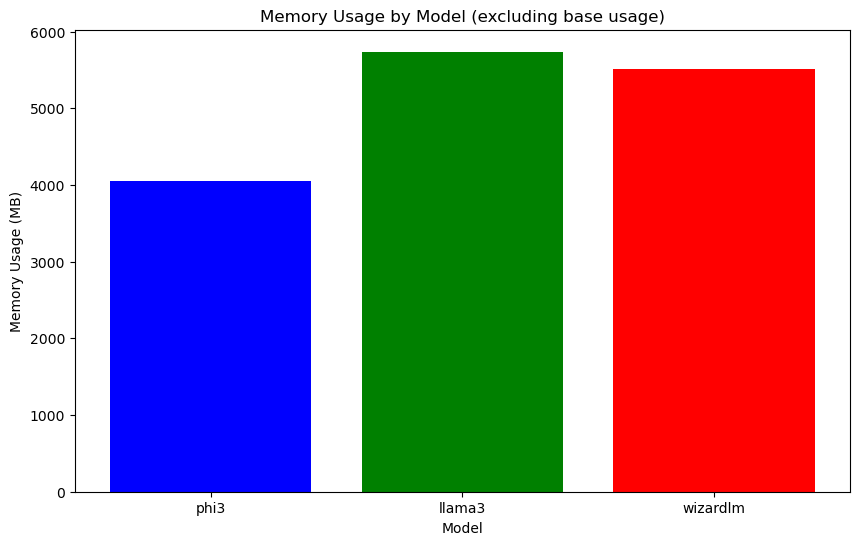

In [27]:
# Base memory usage
base_memory_usage = 1889 # MB

# Compute gross memory measurements with nvidia-smi minus base usage
phi3_memory_usage = 5935 - base_memory_usage # MB
llama3_memory_usage = 7626 - base_memory_usage # MB
wizardlm_memory_usage = 7403 - base_memory_usage # MB

# Data for plotting
models = ['phi3', 'llama3', 'wizardlm']
memory_usage = [phi3_memory_usage, llama3_memory_usage, wizardlm_memory_usage]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, memory_usage, color=['blue', 'green', 'red'])

plt.title('Memory Usage by Model (excluding base usage)')
plt.xlabel('Model')
plt.ylabel('Memory Usage (MB)')
plt.show()

In [28]:
with open('results/tool-count-eval-m1-max.json', 'r') as file:
    data = json.load(file)

In [29]:
records = []

for tool_count, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'tool_count': tool_count,
            'tool': tool,
            'median_latency': metrics['median_latency'],
            'pass_percentage': metrics['pass_percentage'],
        })

df = pd.DataFrame(records)

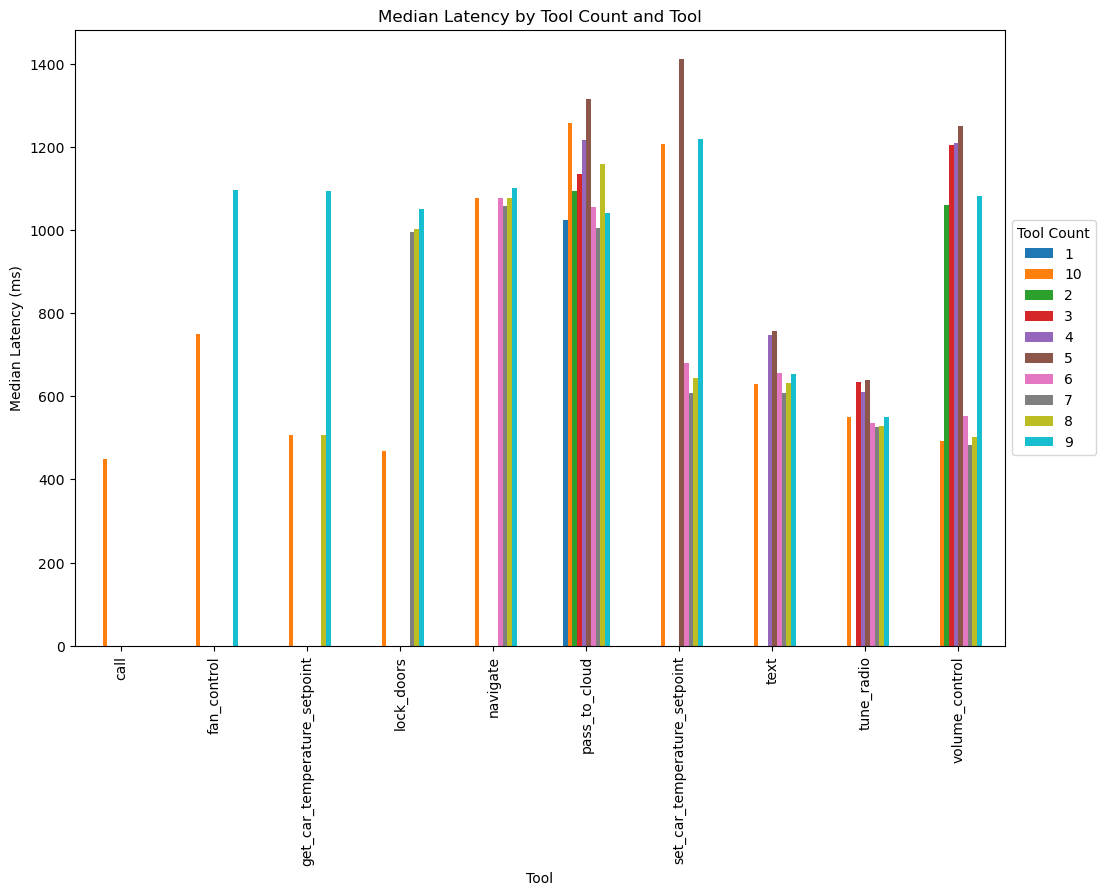

In [30]:
# Pivot the DataFrame to have tool counts as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='tool_count', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

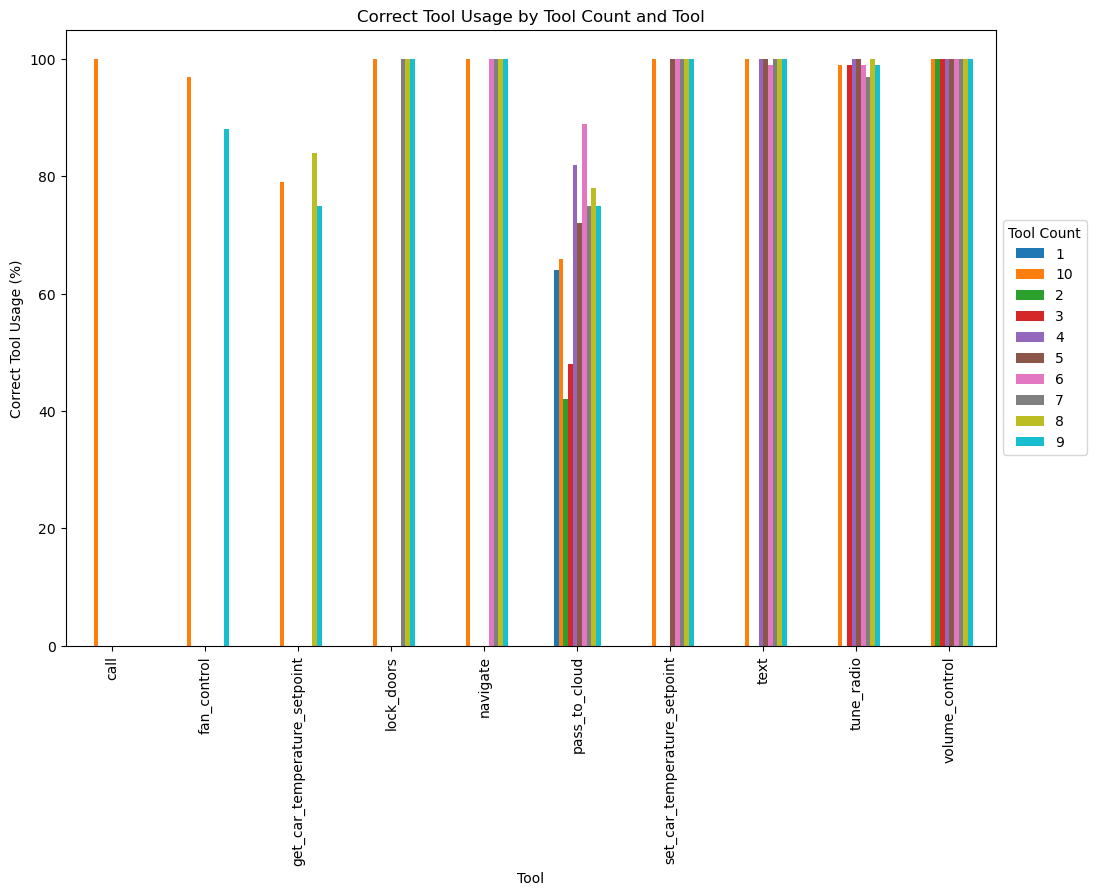

In [31]:
pivot_df = df.pivot(index='tool', columns='tool_count', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Tool Usage by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Correct Tool Usage (%)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

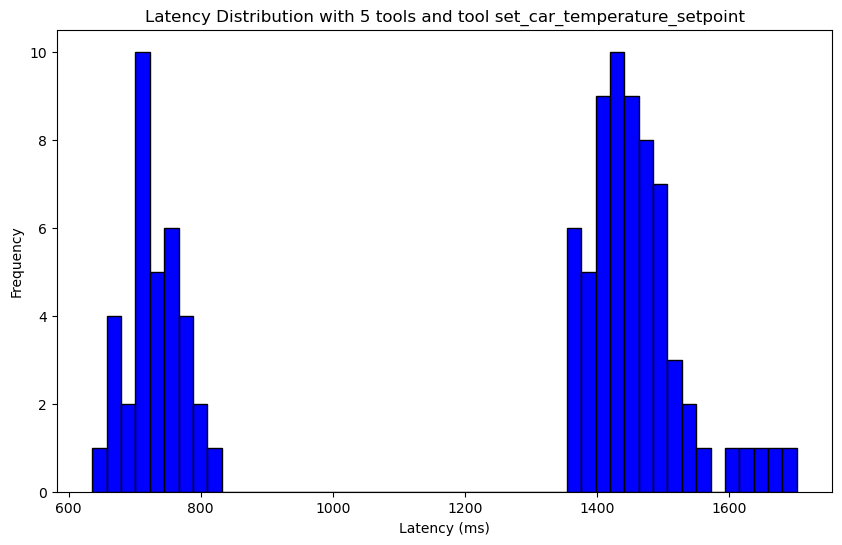

In [32]:
import numpy as np
import matplotlib.pyplot as plt

tool_count = '5'
tool_name = 'set_car_temperature_setpoint'

five_tool_count = data[tool_count]
latencies = five_tool_count[tool_name]['latencies']

# Create bins for the histogram
min_latency = min(latencies)
max_latency = max(latencies)
bins = np.linspace(min_latency, max_latency, 50)

# Plotting the latency distribution
plt.figure(figsize=(10, 6))
plt.hist(latencies, bins=bins, edgecolor='black', color='blue')

plt.title(f'Latency Distribution with {tool_count} tools and tool {tool_name}')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Are there user inputs that are more likely to fail?
# How does hardware effect latency (4800 vs. M1 Max vs M4)?